# install modules

In [1]:
! pip install chembl_webresource_client

     |████████████████████████████████| 55 kB 1.5 MB/s 
     |████████████████████████████████| 596 kB 14.9 MB/s 
  Attempting uninstall: pyyaml
    Found existing installation: PyYAML 3.13
    Uninstalling PyYAML-3.13:
      Successfully uninstalled PyYAML-3.13
  Attempting uninstall: itsdangerous
    Found existing installation: itsdangerous 1.1.0
    Uninstalling itsdangerous-1.1.0:
      Successfully uninstalled itsdangerous-1.1.0
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
flask 1.1.4 requires itsdangerous<2.0,>=0.24, but you have itsdangerous 2.0.1 which is incompatible.


In [2]:
! wget https://repo.anaconda.com/miniconda/Miniconda3-py37_4.8.2-Linux-x86_64.sh
! chmod +x Miniconda3-py37_4.8.2-Linux-x86_64.sh
! bash ./Miniconda3-py37_4.8.2-Linux-x86_64.sh -b -f -p /usr/local
import sys
sys.path.append('/usr/local/lib/python3.7/site-packages/')

! conda install -c rdkit rdkit -y

--2021-12-16 03:21:18--  https://repo.anaconda.com/miniconda/Miniconda3-py37_4.8.2-Linux-x86_64.sh
Resolving repo.anaconda.com (repo.anaconda.com)... 104.16.131.3, 104.16.130.3, 2606:4700::6810:8203, ...
Connecting to repo.anaconda.com (repo.anaconda.com)|104.16.131.3|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 85055499 (81M) [application/x-sh]
Saving to: ‘Miniconda3-py37_4.8.2-Linux-x86_64.sh’

Miniconda3-py37_4.8 100%[===================>]  81.12M   176MB/s    in 0.5s    

2021-12-16 03:21:19 (176 MB/s) - ‘Miniconda3-py37_4.8.2-Linux-x86_64.sh’ saved [85055499/85055499]

PREFIX=/usr/local
Unpacking payload ...
Solving environment: - done

## Package Plan ##

  environment location: /usr/local

  added / updated specs:
    - _libgcc_mutex==0.1=main
    - asn1crypto==1.3.0=py37_0
    - ca-certificates==2020.1.1=0
    - certifi==2019.11.28=py37_0
    - cffi==1.14.0=py37h2e261b9_0
    - chardet==3.0.4=py37_1003
    - conda-package-handling==1.6.0=py37h7b64

In [3]:
! pip install MolVS

     |████████████████████████████████| 61 kB 426 kB/s 
  Created wheel for MolVS: filename=MolVS-0.1.1-py3-none-any.whl size=32376 sha256=ae658c613054734e3ab6a80d2f70a725f9f69d503dc8acf4f9de6fd827da722c
  Stored in directory: /root/.cache/pip/wheels/c4/c2/92/e85190307603c2b3733d43e357abae2d1c66b609bfbba6200d
Successfully built MolVS


# PART 1: target ACH

## import modules


In [4]:
# Import necessary libraries
import pandas as pd
from chembl_webresource_client.new_client import new_client
import pandas as pd
import molvs as mv
from molvs.standardize import standardize_smiles
from rdkit import Chem
from rdkit.Chem.MolStandardize import rdMolStandardize
from rdkit.Chem import Descriptors, Lipinski
import numpy as np

## get activity data

In [ ]:
# Target search for coronavirus
target = new_client.target
target_query = target.search('acetylcholinesterase')
targets = pd.DataFrame.from_dict(target_query)
selected_target = targets.target_chembl_id[0]
selected_target

'CHEMBL220'

In [ ]:
activity = new_client.activity
res = activity.filter(target_chembl_id=selected_target).filter(standard_type="IC50")
df = pd.DataFrame.from_dict(res)
#df

,activity_comment,activity_id,activity_properties,assay_chembl_id,assay_description,assay_type,assay_variant_accession,assay_variant_mutation,bao_endpoint,bao_format,bao_label,canonical_smiles,data_validity_comment,data_validity_description,document_chembl_id,document_journal,document_year,ligand_efficiency,molecule_chembl_id,molecule_pref_name,parent_molecule_chembl_id,pchembl_value,potential_duplicate,qudt_units,record_id,relation,src_id,standard_flag,standard_relation,standard_text_value,standard_type,standard_units,standard_upper_value,standard_value,target_chembl_id,target_organism,target_pref_name,target_tax_id,text_value,toid,type,units,uo_units,upper_value,value
0,None,33969,[],CHEMBL643384,Inhibitory concentration against acetylcholine...,B,None,None,BAO_0000190,BAO_0000357,single protein format,CCOc1nn(-c2cccc(OCc3ccccc3)c2)c(=O)o1,None,None,CHEMBL1148382,J. Med. Chem.,2004.0,"{'bei': '19.61', 'le': '0.36', 'lle': '3.32', ...",CHEMBL133897,None,CHEMBL133897,6.12,False,http://www.openphacts.org/units/Nanomolar,252547,=,1,True,=,None,IC50,nM,None,750.0,CHEMBL220,Homo sapiens,Acetylcholinesterase,9606,None,None,IC50,uM,UO_0000065,None,0.75
1,None,37563,[],CHEMBL643384,Inhibitory concentration against acetylcholine...,B,None,None,BAO_0000190,BAO_0000357,single protein format,O=C(N1CCCCC1)n1nc(-c2ccc(Cl)cc2)nc1SCC1CC1,None,None,CHEMBL1148382,J. Med. Chem.,2004.0,"{'bei': '18.57', 'le': '0.38', 'lle': '2.45', ...",CHEMBL336398,None,CHEMBL336398,7.00,False,http://www.openphacts.org/units/Nanomolar,252533,=,1,True,=,None,IC50,nM,None,100.0,CHEMBL220,Homo sapiens,Acetylcholinesterase,9606,None,None,IC50,uM,UO_0000065,None,0.1
2,None,37565,[],CHEMBL643384,Inhibitory concentration against acetylcholine...,B,None,None,BAO_0000190,BAO_0000357,single protein format,CN(C(=O)n1nc(-c2ccc(Cl)cc2)nc1SCC(F)(F)F)c1ccccc1,None,None,CHEMBL1148382,J. Med. Chem.,2004.0,None,CHEMBL131588,None,CHEMBL131588,None,False,http://www.openphacts.org/units/Nanomolar,252530,>,1,True,>,None,IC50,nM,None,50000.0,CHEMBL220,Homo sapiens,Acetylcholinesterase,9606,None,None,IC50,uM,UO_0000065,None,50.0
3,None,38902,[],CHEMBL643384,Inhibitory concentration against acetylcholine...,B,None,None,BAO_0000190,BAO_0000357,single protein format,O=C(N1CCCCC1)n1nc(-c2ccc(Cl)cc2)nc1SCC(F)(F)F,None,None,CHEMBL1148382,J. Med. Chem.,2004.0,"{'bei': '16.11', 'le': '0.34', 'lle': '1.81', ...",CHEMBL130628,None,CHEMBL130628,6.52,False,http://www.openphacts.org/units/Nanomolar,252534,=,1,True,=,None,IC50,nM,None,300.0,CHEMBL220,Homo sapiens,Acetylcholinesterase,9606,None,None,IC50,uM,UO_0000065,None,0.3
4,None,41170,[],CHEMBL643384,Inhibitory concentration against acetylcholine...,B,None,None,BAO_0000190,BAO_0000357,single protein format,CSc1nc(-c2ccc(OC(F)(F)F)cc2)nn1C(=O)N(C)C,None,None,CHEMBL1148382,J. Med. Chem.,2004.0,"{'bei': '17.60', 'le': '0.36', 'lle': '3.00', ...",CHEMBL130478,None,CHEMBL130478,6.10,False,http://www.openphacts.org/units/Nanomolar,252552,=,1,True,=,None,IC50,nM,None,800.0,CHEMBL220,Homo sapiens,Acetylcholinesterase,9606,None,None,IC50,uM,UO_0000065,None,0.8
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7544,None,20703835,[],CHEMBL4627889,Inhibition of AChE (unknown origin) using acet...,B,None,None,BAO_0000190,BAO_0000357,single protein format,COc1ccc(CCC(=O)Nc2nc(-c3cc4ccccc4oc3=O)cs2)cc1OC,None,None,CHEMBL4627271,Bioorg Med Chem Lett,2020.0,"{'bei': '14.05', 'le': '0.27', 'lle': '1.62', ...",CHEMBL4645659,None,CHEMBL4645659,6.13,False,http://www.openphacts.org/units/Nanomolar,3486808,=,1,True,=,None,IC50,nM,None,740.0,CHEMBL220,Homo sapiens,Acetylcholinesterase,9606,None,None,IC50,uM,UO_0000065,None,0.74
7545,None,20703856,[],CHEMBL4627888,Inhibition of AChE (unknown origin),B,None,None,BAO_0000190,BAO_0000357,single protein format,COc1ccc(-c2csc(NC(=O)CCN3CCCC3)n2)cc1,None,None,CHEMBL4627271,Bioorg Med Chem Lett

In [ ]:
df.to_csv('chembl_acetylcholinesterase_bioactivity_data_raw.csv', index=False)


In [56]:
df = pd.read_csv('chembl_acetylcholinesterase_bioactivity_data_raw.csv')
df.head()

,activity_comment,activity_id,activity_properties,assay_chembl_id,assay_description,assay_type,assay_variant_accession,assay_variant_mutation,bao_endpoint,bao_format,bao_label,canonical_smiles,data_validity_comment,data_validity_description,document_chembl_id,document_journal,document_year,ligand_efficiency,molecule_chembl_id,molecule_pref_name,parent_molecule_chembl_id,pchembl_value,potential_duplicate,qudt_units,record_id,relation,src_id,standard_flag,standard_relation,standard_text_value,standard_type,standard_units,standard_upper_value,standard_value,target_chembl_id,target_organism,target_pref_name,target_tax_id,text_value,toid,type,units,uo_units,upper_value,value
0,NaN,33969,[],CHEMBL643384,Inhibitory concentration against acetylcholine...,B,NaN,NaN,BAO_0000190,BAO_0000357,single protein format,CCOc1nn(-c2cccc(OCc3ccccc3)c2)c(=O)o1,NaN,NaN,CHEMBL1148382,J. Med. Chem.,2004.0,"{'bei': '19.61', 'le': '0.36', 'lle': '3.32', ...",CHEMBL133897,NaN,CHEMBL133897,6.12,False,http://www.openphacts.org/units/Nanomolar,252547,=,1,True,=,NaN,IC50,nM,NaN,750.0,CHEMBL220,Homo sapiens,Acetylcholinesterase,9606,NaN,NaN,IC50,uM,UO_0000065,NaN,0.75
1,NaN,37563,[],CHEMBL643384,Inhibitory concentration against acetylcholine...,B,NaN,NaN,BAO_0000190,BAO_0000357,single protein format,O=C(N1CCCCC1)n1nc(-c2ccc(Cl)cc2)nc1SCC1CC1,NaN,NaN,CHEMBL1148382,J. Med. Chem.,2004.0,"{'bei': '18.57', 'le': '0.38', 'lle': '2.45', ...",CHEMBL336398,NaN,CHEMBL336398,7.00,False,http://www.openphacts.org/units/Nanomolar,252533,=,1,True,=,NaN,IC50,nM,NaN,100.0,CHEMBL220,Homo sapiens,Acetylcholinesterase,9606,NaN,NaN,IC50,uM,UO_0000065,NaN,0.10
2,NaN,37565,[],CHEMBL643384,Inhibitory concentration against acetylcholine...,B,NaN,NaN,BAO_0000190,BAO_0000357,single protein format,CN(C(=O)n1nc(-c2ccc(Cl)cc2)nc1SCC(F)(F)F)c1ccccc1,NaN,NaN,CHEMBL1148382,J. Med. Chem.,2004.0,NaN,CHEMBL131588,NaN,CHEMBL131588,NaN,False,http://www.openphacts.org/units/Nanomolar,252530,>,1,True,>,NaN,IC50,nM,NaN,50000.0,CHEMBL220,Homo sapiens,Acetylcholinesterase,9606,NaN,NaN,IC50,uM,UO_0000065,NaN,50.00
3,NaN,38902,[],CHEMBL643384,Inhibitory concentration against acetylcholine...,B,NaN,NaN,BAO_0000190,BAO_0000357,single protein format,O=C(N1CCCCC1)n1nc(-c2ccc(Cl)cc2)nc1SCC(F)(F)F,NaN,NaN,CHEMBL1148382,J. Med. Chem.,2004.0,"{'bei': '16.11', 'le': '0.34', 'lle': '1.81', ...",CHEMBL130628,NaN,CHEMBL130628,6.52,False,http://www.openphacts.org/units/Nanomolar,252534,=,1,True,=,NaN,IC50,nM,NaN,300.0,CHEMBL220,Homo sapiens,Acetylcholinesterase,9606,NaN,NaN,IC50,uM,UO_0000065,NaN,0.30
4,NaN,41170,[],CHEMBL643384,Inhibitory concentration against acetylcholine...,B,NaN,NaN,BAO_0000190,BAO_0000357,single protein format,CSc1nc(-c2ccc(OC(F)(F)F)cc2)nn1C(=O)N(C)C,NaN,NaN,CHEMBL1148382,J. Med. Chem.,2004.0,"{'bei': '17.60', 'le': '0.36', 'lle': '3.00', ...",CHEMBL130478,NaN,CHEMBL130478,6.10,False,http://www.openphacts.org/units/Nanomolar,252552,=,1,True,=,NaN,IC50,nM,NaN,800.0,CHEMBL220,Homo sapiens,Acetylcholinesterase,9606,NaN,NaN,IC50,uM,UO_0000065,NaN,0.80


## data process 

In [57]:
# neutralize the molecules
def un_charge_molecule(smi):
    try:
        un = rdMolStandardize.Uncharger()
        mol = Chem.MolFromSmiles(smi)
        un_mol = un.uncharge(mol)
        res_smi = Chem.MolToSmiles(un_mol)
        return res_smi
    except:
        return "NaN"

In [58]:
# remove trival molecules
def choose_largest_frag(smi):
    try:
        mol = Chem.MolFromSmiles(smi)
        # setup standardization module
        largest_Fragment = rdMolStandardize.LargestFragmentChooser()
        largest_mol = largest_Fragment.choose(mol)
        smi_res = Chem.MolToSmiles(largest_mol)
        return smi_res
    except:
        print("%s failed conversion"%smi)
        return "NaN"

In [59]:
df.shape

(7549, 45)

In [60]:
df2 = df[df.standard_value.notna()]
print(df2.shape)
df2 = df2[df.canonical_smiles.notna()]
print(df2.shape)
df2 = df2[df2['assay_type']=='B']
print(df2.shape)
df2 = df2[df2['standard_relation']=='=']
print(df2.shape)
df2 = df2[df2['standard_units']=='nM']
print(df2.shape)

(6342, 45)
(6340, 45)
(6233, 45)
(5655, 45)
(5635, 45)


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  This is separate from the ipykernel package so we can avoid doing imports until


In [13]:
df2.units.unique()

array(['uM', 'mM', 'nM', nan, 'M', 'pM', "10'-5M", "10'-3M", "10'-2M",
       "10'-4M", "10'-7M", "10'-9M", "10'-6M", "10'-8M", "10'-3microM",
       "10'-4microM", 'uM/L', "10'-10M", 'umol', 'umol/L', "10'2pM",
       "10'-12M", "10'-2microM"], dtype=object)

In [61]:
df2['canonical_smiles'] = df2['canonical_smiles'].apply(standardize_smiles)
df2['canonical_smiles'] = df2['canonical_smiles'].apply(un_charge_molecule)
df2['canonical_smiles'] = df2['canonical_smiles'].apply(choose_largest_frag)
df2.head()

,activity_comment,activity_id,activity_properties,assay_chembl_id,assay_description,assay_type,assay_variant_accession,assay_variant_mutation,bao_endpoint,bao_format,bao_label,canonical_smiles,data_validity_comment,data_validity_description,document_chembl_id,document_journal,document_year,ligand_efficiency,molecule_chembl_id,molecule_pref_name,parent_molecule_chembl_id,pchembl_value,potential_duplicate,qudt_units,record_id,relation,src_id,standard_flag,standard_relation,standard_text_value,standard_type,standard_units,standard_upper_value,standard_value,target_chembl_id,target_organism,target_pref_name,target_tax_id,text_value,toid,type,units,uo_units,upper_value,value
0,NaN,33969,[],CHEMBL643384,Inhibitory concentration against acetylcholine...,B,NaN,NaN,BAO_0000190,BAO_0000357,single protein format,CCOc1nn(-c2cccc(OCc3ccccc3)c2)c(=O)o1,NaN,NaN,CHEMBL1148382,J. Med. Chem.,2004.0,"{'bei': '19.61', 'le': '0.36', 'lle': '3.32', ...",CHEMBL133897,NaN,CHEMBL133897,6.12,False,http://www.openphacts.org/units/Nanomolar,252547,=,1,True,=,NaN,IC50,nM,NaN,750.0,CHEMBL220,Homo sapiens,Acetylcholinesterase,9606,NaN,NaN,IC50,uM,UO_0000065,NaN,0.75
1,NaN,37563,[],CHEMBL643384,Inhibitory concentration against acetylcholine...,B,NaN,NaN,BAO_0000190,BAO_0000357,single protein format,O=C(N1CCCCC1)n1nc(-c2ccc(Cl)cc2)nc1SCC1CC1,NaN,NaN,CHEMBL1148382,J. Med. Chem.,2004.0,"{'bei': '18.57', 'le': '0.38', 'lle': '2.45', ...",CHEMBL336398,NaN,CHEMBL336398,7.00,False,http://www.openphacts.org/units/Nanomolar,252533,=,1,True,=,NaN,IC50,nM,NaN,100.0,CHEMBL220,Homo sapiens,Acetylcholinesterase,9606,NaN,NaN,IC50,uM,UO_0000065,NaN,0.10
3,NaN,38902,[],CHEMBL643384,Inhibitory concentration against acetylcholine...,B,NaN,NaN,BAO_0000190,BAO_0000357,single protein format,O=C(N1CCCCC1)n1nc(-c2ccc(Cl)cc2)nc1SCC(F)(F)F,NaN,NaN,CHEMBL1148382,J. Med. Chem.,2004.0,"{'bei': '16.11', 'le': '0.34', 'lle': '1.81', ...",CHEMBL130628,NaN,CHEMBL130628,6.52,False,http://www.openphacts.org/units/Nanomolar,252534,=,1,True,=,NaN,IC50,nM,NaN,300.0,CHEMBL220,Homo sapiens,Acetylcholinesterase,9606,NaN,NaN,IC50,uM,UO_0000065,NaN,0.30
4,NaN,41170,[],CHEMBL643384,Inhibitory concentration against acetylcholine...,B,NaN,NaN,BAO_0000190,BAO_0000357,single protein format,CSc1nc(-c2ccc(OC(F)(F)F)cc2)nn1C(=O)N(C)C,NaN,NaN,CHEMBL1148382,J. Med. Chem.,2004.0,"{'bei': '17.60', 'le': '0.36', 'lle': '3.00', ...",CHEMBL130478,NaN,CHEMBL130478,6.10,False,http://www.openphacts.org/units/Nanomolar,252552,=,1,True,=,NaN,IC50,nM,NaN,800.0,CHEMBL220,Homo sapiens,Acetylcholinesterase,9606,NaN,NaN,IC50,uM,UO_0000065,NaN,0.80
5,NaN,42363,[],CHEMBL643384,Inhibitory concentration against acetylcholine...,B,NaN,NaN,BAO_0000190,BAO_0000357,single protein format,CSc1nc(-c2ccc(C)cc2)nn1C(=O)N(C)c1ccccc1,NaN,NaN,CHEMBL1148382,J. Med. Chem.,2004.0,"{'bei': '16.60', 'le': '0.32', 'lle': '1.54', ...",CHEMBL130112,NaN,CHEMBL130112,5.62,False,http://www.openphacts.org/units/Nanomolar,252551,=,1,True,=,NaN,IC50,nM,NaN,2400.0,CHEMBL220,Homo sapiens,Acetylcholinesterase,9606,NaN,NaN,IC50,uM,UO_0000065,NaN,2.40


In [62]:
df2.bao_label.value_counts()

single protein format    4808
assay format              481
cell-based format         332
tissue-based format        12
subcellular format          2
Name: bao_label, dtype: int64

In [63]:
df2_activity_sub = df2[df2['bao_label']=='single protein format']
df2_activity_sub.shape

(4808, 45)

In [64]:
df2_activity_sub_nr = df2_activity_sub.drop_duplicates(['canonical_smiles'])
df2_activity_sub_nr.shape

(3791, 45)

In [65]:
df2_activity_sub_nr.reset_index(drop=True, inplace=True)

In [66]:
df3 = df2_activity_sub_nr[['molecule_chembl_id','canonical_smiles', 'standard_type', 'standard_relation', 'standard_value', 'standard_units']]

In [67]:
def lipinski(smiles, verbose=False):

    moldata= []
    for elem in smiles:
        mol=Chem.MolFromSmiles(elem) 
        moldata.append(mol)
       
    baseData= np.arange(1,1)
    i=0  
    for mol in moldata:        
       
        desc_MolWt = Descriptors.MolWt(mol)
        desc_MolLogP = Descriptors.MolLogP(mol)
        desc_NumHDonors = Lipinski.NumHDonors(mol)
        desc_NumHAcceptors = Lipinski.NumHAcceptors(mol)
           
        row = np.array([desc_MolWt,
                        desc_MolLogP,
                        desc_NumHDonors,
                        desc_NumHAcceptors])   
    
        if(i==0):
            baseData=row
        else:
            baseData=np.vstack([baseData, row])
        i=i+1      
    
    columnNames=["MW","LogP","NumHDonors","NumHAcceptors"]   
    descriptors = pd.DataFrame(data=baseData,columns=columnNames)
    
    return descriptors

In [68]:
df_lipinski = lipinski(df3.canonical_smiles)
df3_w_lipinski = pd.concat([df3,df_lipinski], axis=1)

In [69]:
df3_w_lipinski = df3_w_lipinski[(df3_w_lipinski['MW'] < 800) & (df3_w_lipinski['MW'] > 150)]
df3_w_lipinski = df3_w_lipinski[(df3_w_lipinski['LogP'] < 8) & (df3_w_lipinski['LogP'] > -5)]
df3_w_lipinski = df3_w_lipinski[df3_w_lipinski['NumHDonors'] <= 8]
df3_w_lipinski = df3_w_lipinski[df3_w_lipinski['NumHAcceptors'] <= 10]
df3_w_lipinski

,molecule_chembl_id,canonical_smiles,standard_type,standard_relation,standard_value,standard_units,MW,LogP,NumHDonors,NumHAcceptors
0,CHEMBL133897,CCOc1nn(-c2cccc(OCc3ccccc3)c2)c(=O)o1,IC50,=,750.0,nM,312.325,2.80320,0.0,6.0
1,CHEMBL336398,O=C(N1CCCCC1)n1nc(-c2ccc(Cl)cc2)nc1SCC1CC1,IC50,=,100.0,nM,376.913,4.55460,0.0,5.0
2,CHEMBL130628,O=C(N1CCCCC1)n1nc(-c2ccc(Cl)cc2)nc1SCC(F)(F)F,IC50,=,300.0,nM,404.845,4.70690,0.0,5.0
3,CHEMBL130478,CSc1nc(-c2ccc(OC(F)(F)F)cc2)nn1C(=O)N(C)C,IC50,=,800.0,nM,346.334,3.09530,0.0,6.0
4,CHEMBL130112,CSc1nc(-c2ccc(C)cc2)nn1C(=O)N(C)c1ccccc1,IC50,=,2400.0,nM,338.436,4.07992,0.0,5.0
...,...,...,...,...,...,...,...,...,...,...
3786,CHEMBL4638958,CC(C)=CC[C@H]1C[C@]2(CC=C(C)C)C(=O)[C@]3(CC=C(...,IC50,=,20700.0,nM,484.677,5.70360,1.0,5.0
3787,CHEMBL4635686,CN(C)C(=O)Oc1cccc(C(O)CNC2CCCCC2)c1,IC50,=,792000.0,nM,306.406,2.70270,2.0,4.0
3788,CHEMBL4645476,CN(C)C(=O)Oc1ccc(C(O)CNC2CCCCC2)cc1,IC50,=,266000.0,nM,306.406,2.70270,2.0,4.0
3789,CHEMBL4645659,COc1ccc(CCC(=O)Nc2nc(-c3cc4ccccc4oc3=O)cs2)cc1OC,IC50,=,740.0,nM,436.489,4.50500,1.0,7.0


In [70]:
# IC50 to pIC50
def pIC50(input):
  molar = input*(10**-9)
  pIC50_val = -np.log10(molar)
  if pIC50_val > 9:
    pIC50_val = 9
  return pIC50_val

# add class info
def pic50_to_2class(pic50):
    if pic50 < 7:
        return 0
    else:
        return 1

In [71]:
df3_w_lipinski['pIC50'] = df3_w_lipinski['standard_value'].apply(pIC50)
df3_w_lipinski['Classification'] = df3_w_lipinski['pIC50'].apply(pic50_to_2class)
df3_w_lipinski

,molecule_chembl_id,canonical_smiles,standard_type,standard_relation,standard_value,standard_units,MW,LogP,NumHDonors,NumHAcceptors,pIC50,Classification
0,CHEMBL133897,CCOc1nn(-c2cccc(OCc3ccccc3)c2)c(=O)o1,IC50,=,750.0,nM,312.325,2.80320,0.0,6.0,6.124939,0
1,CHEMBL336398,O=C(N1CCCCC1)n1nc(-c2ccc(Cl)cc2)nc1SCC1CC1,IC50,=,100.0,nM,376.913,4.55460,0.0,5.0,7.000000,1
2,CHEMBL130628,O=C(N1CCCCC1)n1nc(-c2ccc(Cl)cc2)nc1SCC(F)(F)F,IC50,=,300.0,nM,404.845,4.70690,0.0,5.0,6.522879,0
3,CHEMBL130478,CSc1nc(-c2ccc(OC(F)(F)F)cc2)nn1C(=O)N(C)C,IC50,=,800.0,nM,346.334,3.09530,0.0,6.0,6.096910,0
4,CHEMBL130112,CSc1nc(-c2ccc(C)cc2)nn1C(=O)N(C)c1ccccc1,IC50,=,2400.0,nM,338.436,4.07992,0.0,5.0,5.619789,0
...,...,...,...,...,...,...,...,...,...,...,...,...
3786,CHEMBL4638958,CC(C)=CC[C@H]1C[C@]2(CC=C(C)C)C(=O)[C@]3(CC=C(...,IC50,=,20700.0,nM,484.677,5.70360,1.0,5.0,4.684030,0
3787,CHEMBL4635686,CN(C)C(=O)Oc1cccc(C(O)CNC2CCCCC2)c1,IC50,=,792000.0,nM,306.406,2.70270,2.0,4.0,3.101275,0
3788,CHEMBL4645476,CN(C)C(=O)Oc1ccc(C(O)CNC2CCCCC2)cc1,IC50,=,266000.0,nM,306.406,2.70270,2.0,4.0,3.575118,0
3789,CHEMBL4645659,COc1ccc(CCC(=O)Nc2nc(-c3cc4ccccc4oc3=O)cs2)cc1OC,IC50,=,740.0,nM,436.489,4.50500,1.0,7.0,6.130768,0


In [72]:
#df_final = df3_w_lipinski.reset_index(drop=True, inplace=True)
df_final = df3_w_lipinski.reset_index(drop=True)
df_final

,molecule_chembl_id,canonical_smiles,standard_type,standard_relation,standard_value,standard_units,MW,LogP,NumHDonors,NumHAcceptors,pIC50,Classification
0,CHEMBL133897,CCOc1nn(-c2cccc(OCc3ccccc3)c2)c(=O)o1,IC50,=,750.0,nM,312.325,2.80320,0.0,6.0,6.124939,0
1,CHEMBL336398,O=C(N1CCCCC1)n1nc(-c2ccc(Cl)cc2)nc1SCC1CC1,IC50,=,100.0,nM,376.913,4.55460,0.0,5.0,7.000000,1
2,CHEMBL130628,O=C(N1CCCCC1)n1nc(-c2ccc(Cl)cc2)nc1SCC(F)(F)F,IC50,=,300.0,nM,404.845,4.70690,0.0,5.0,6.522879,0
3,CHEMBL130478,CSc1nc(-c2ccc(OC(F)(F)F)cc2)nn1C(=O)N(C)C,IC50,=,800.0,nM,346.334,3.09530,0.0,6.0,6.096910,0
4,CHEMBL130112,CSc1nc(-c2ccc(C)cc2)nn1C(=O)N(C)c1ccccc1,IC50,=,2400.0,nM,338.436,4.07992,0.0,5.0,5.619789,0
...,...,...,...,...,...,...,...,...,...,...,...,...
3552,CHEMBL4638958,CC(C)=CC[C@H]1C[C@]2(CC=C(C)C)C(=O)[C@]3(CC=C(...,IC50,=,20700.0,nM,484.677,5.70360,1.0,5.0,4.684030,0
3553,CHEMBL4635686,CN(C)C(=O)Oc1cccc(C(O)CNC2CCCCC2)c1,IC50,=,792000.0,nM,306.406,2.70270,2.0,4.0,3.101275,0
3554,CHEMBL4645476,CN(C)C(=O)Oc1ccc(C(O)CNC2CCCCC2)cc1,IC50,=,266000.0,nM,306.406,2.70270,2.0,4.0,3.575118,0
3555,CHEMBL4645659,COc1ccc(CCC(=O)Nc2nc(-c3cc4ccccc4oc3=O)cs2)cc1OC,IC50,=,740.0,nM,436.489,4.50500,1.0,7.0,6.130768,0


In [73]:
df_final.describe()

,standard_value,MW,LogP,NumHDonors,NumHAcceptors,pIC50,Classification
count,3.557000e+03,3557.000000,3557.000000,3557.000000,3557.000000,3557.000000,3557.000000
mean,9.964689e+04,398.631644,4.310891,1.139443,4.388530,5.976621,0.249930
std,1.136678e+06,105.769612,1.670875,1.057518,1.861565,1.415617,0.433033
min,5.000000e-06,151.233000,-2.425900,0.000000,0.000000,1.304518,0.000000
25%,1.009300e+02,331.441000,3.274400,0.000000,3.000000,5.005683,0.000000
50%,1.250000e+03,390.571000,4.325600,1.000000,4.000000,5.903090,0.000000
75%,9.870000e+03,459.586000,5.409760,2.000000,6.000000,6.995980,0.000000
max,4.960000e+07,790.682000,7.997300,7.000000,10.000000,9.000000,1.000000


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:25: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


Text(0.5, 1.0, 'Class')

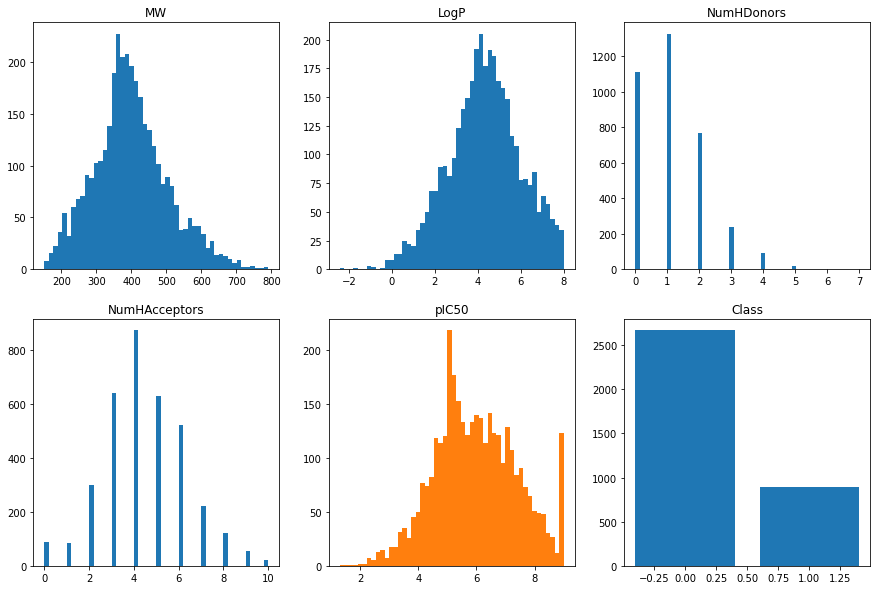

In [94]:
import matplotlib
import matplotlib.pyplot as plt

fig=plt.figure(figsize=(15,10))
ax1=fig.add_subplot(2,3,1)
ax1.hist(df_final['MW'], bins=50)
plt.title('MW')

ax1=fig.add_subplot(2,3,2)
ax1.hist(df_final['LogP'], bins=50)
plt.title('LogP')

ax1=fig.add_subplot(2,3,3)
ax1.hist(df_final['NumHDonors'], bins=50)
plt.title('NumHDonors')

ax1=fig.add_subplot(2,3,4)
ax1.hist(df_final['NumHAcceptors'], bins=50)
plt.title('NumHAcceptors')

ax1=fig.add_subplot(2,3,5)
ax1.hist(df_final['pIC50'], bins=50)
plt.title('pIC50')

ax1=fig.add_subplot(2,3,5)
ax1.hist(df_final['pIC50'], bins=50)
plt.title('pIC50')

ax1=fig.add_subplot(2,3,6)
counts = df_final['Classification'].value_counts()
ax1.bar(counts.index, counts.values)
plt.title('Class')

In [96]:
df_final.to_csv('chembl_acetylcholinesterase_bioactivity_data_processed.csv', index=False)

# PART 2: BACE1

In [ ]:
# # Import necessary libraries
import pandas as pd
from chembl_webresource_client.new_client import new_client
import pandas as pd
import molvs as mv
from molvs.standardize import standardize_smiles
from rdkit import Chem
from rdkit.Chem.MolStandardize import rdMolStandardize
from rdkit.Chem import Descriptors, Lipinski
import numpy as np

## get data

In [ ]:
# Target search for coronavirus
target = new_client.target
target_query = target.search('BACE1')
targets = pd.DataFrame.from_dict(target_query)
selected_target = targets.target_chembl_id[1]
activity = new_client.activity
res = activity.filter(target_chembl_id=selected_target).filter(standard_type="IC50")
df = pd.DataFrame.from_dict(res)
df

,activity_comment,activity_id,activity_properties,assay_chembl_id,assay_description,assay_type,assay_variant_accession,assay_variant_mutation,bao_endpoint,bao_format,bao_label,canonical_smiles,data_validity_comment,data_validity_description,document_chembl_id,document_journal,document_year,ligand_efficiency,molecule_chembl_id,molecule_pref_name,parent_molecule_chembl_id,pchembl_value,potential_duplicate,qudt_units,record_id,relation,src_id,standard_flag,standard_relation,standard_text_value,standard_type,standard_units,standard_upper_value,standard_value,target_chembl_id,target_organism,target_pref_name,target_tax_id,text_value,toid,type,units,uo_units,upper_value,value
0,None,78857,[],CHEMBL653511,Inhibitory activity against Beta-secretase 1 w...,B,None,None,BAO_0000190,BAO_0000357,single protein format,CC(C)C[C@H](NC(=O)[C@@H](NC(=O)[C@@H](N)CCC(=O...,None,None,CHEMBL1136466,Bioorg. Med. Chem. Lett.,2003,"{'bei': '6.39', 'le': '0.12', 'lle': '7.82', '...",CHEMBL406146,HGLUVALLEUPNSASPALAGLUPHEOH,CHEMBL406146,6.38,False,http://www.openphacts.org/units/Nanomolar,260010,=,1,True,=,None,IC50,nM,None,413.0,CHEMBL4822,Homo sapiens,Beta-secretase 1,9606,None,None,IC50,nM,UO_0000065,None,413.0
1,None,391560,[],CHEMBL653332,Compound was tested for its inhibitory activit...,B,None,None,BAO_0000190,BAO_0000357,single protein format,CC(C)C[C@H](NC(=O)[C@H](CC(N)=O)NC(=O)[C@@H](N...,None,None,CHEMBL1144938,J. Med. Chem.,2003,"{'bei': '9.74', 'le': '0.19', 'lle': '10.44', ...",CHEMBL78946,None,CHEMBL78946,8.70,True,http://www.openphacts.org/units/Nanomolar,274693,=,1,True,=,None,IC50,nM,None,2.0,CHEMBL4822,Homo sapiens,Beta-secretase 1,9606,None,None,IC50,uM,UO_0000065,None,0.002
2,None,391983,[],CHEMBL653512,Inhibition of human Beta-secretase 1,B,None,None,BAO_0000190,BAO_0000357,single protein format,CCC(C)C[C@H](NC(=O)[C@H](CC(C)C)NC(C)=O)[C@@H]...,None,None,CHEMBL1147464,Bioorg. Med. Chem. Lett.,2004,"{'bei': '8.43', 'le': '0.17', 'lle': '3.99', '...",CHEMBL324109,None,CHEMBL324109,6.34,False,http://www.openphacts.org/units/Nanomolar,219979,=,1,True,=,None,IC50,nM,None,460.0,CHEMBL4822,Homo sapiens,Beta-secretase 1,9606,None,None,IC50,uM,UO_0000065,None,0.46
3,None,395858,[],CHEMBL653512,Inhibition of human Beta-secretase 1,B,None,None,BAO_0000190,BAO_0000357,single protein format,CC(=O)NCC(=O)N[C@@H](Cc1ccccc1)[C@@H](O)CC(=O)...,None,None,CHEMBL1147464,Bioorg. Med. Chem. Lett.,2004,"{'bei': '6.84', 'le': '0.13', 'lle': '3.09', '...",CHEMBL114147,None,CHEMBL114147,5.05,False,http://www.openphacts.org/units/Nanomolar,219988,=,1,True,=,None,IC50,nM,None,9000.0,CHEMBL4822,Homo sapiens,Beta-secretase 1,9606,None,None,IC50,uM,UO_0000065,None,9.0
4,None,395859,[],CHEMBL653512,Inhibition of human Beta-secretase 1,B,None,None,BAO_0000190,BAO_0000357,single protein format,CC(=O)N[C@@H](Cc1ccccc1)C(=O)N[C@@H](Cc1ccccc1...,None,None,CHEMBL1147464,Bioorg. Med. Chem. Lett.,2004,"{'bei': '6.34', 'le': '0.12', 'lle': '1.68', '...",CHEMBL419949,None,CHEMBL419949,5.25,False,http://www.openphacts.org/units/Nanomolar,219982,=,1,True,=,None,IC50,nM,None,5600.0,CHEMBL4822,Homo sapiens,Beta-secretase 1,9606,None,None,IC50,uM,UO_0000065,None,5.6
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10178,None,20706840,[],CHEMBL4628349,Inhibition of BACE1 (unknown origin) assessed ...,B,None,None,BAO_0000190,BAO_0000219,cell-based format,NC1=N[C@@]2(c3cc(NC(=O)c4cnc(OCF)cn4)ccc3F)CCO...,None,None,CHEMBL4627305,Bioorg Med Chem Lett,2020,"{'bei': '14.93', 'le': '0.29', 'lle': '3.97', ...",CHEMBL4635770,None,CHEMBL4635770,6.77,False,http://www.openphacts.org/units/Nanomolar,3487416,=,1,True,=,None,IC50,nM,None,170.0,CHEMBL4822,Homo sapiens,Beta-secretase 1,9606,None,None,IC50,nM,UO_0000065,None,170.0
10179,None,20706849,[],CHEMBL4628348,Inhibition of BACE1 (unknown origin),B,None,None,BAO_0000190,BAO_0000357,single protein format,C[C

In [ ]:
df.to_csv('chembl_bace_bioactivity_data_raw.csv', index=False)
df = pd.read_csv('chembl_bace_bioactivity_data_raw.csv')
df.head()

,activity_comment,activity_id,activity_properties,assay_chembl_id,assay_description,assay_type,assay_variant_accession,assay_variant_mutation,bao_endpoint,bao_format,bao_label,canonical_smiles,data_validity_comment,data_validity_description,document_chembl_id,document_journal,document_year,ligand_efficiency,molecule_chembl_id,molecule_pref_name,parent_molecule_chembl_id,pchembl_value,potential_duplicate,qudt_units,record_id,relation,src_id,standard_flag,standard_relation,standard_text_value,standard_type,standard_units,standard_upper_value,standard_value,target_chembl_id,target_organism,target_pref_name,target_tax_id,text_value,toid,type,units,uo_units,upper_value,value
0,NaN,78857,[],CHEMBL653511,Inhibitory activity against Beta-secretase 1 w...,B,NaN,NaN,BAO_0000190,BAO_0000357,single protein format,CC(C)C[C@H](NC(=O)[C@@H](NC(=O)[C@@H](N)CCC(=O...,NaN,NaN,CHEMBL1136466,Bioorg. Med. Chem. Lett.,2003,"{'bei': '6.39', 'le': '0.12', 'lle': '7.82', '...",CHEMBL406146,HGLUVALLEUPNSASPALAGLUPHEOH,CHEMBL406146,6.38,False,http://www.openphacts.org/units/Nanomolar,260010,=,1,True,=,NaN,IC50,nM,NaN,413.0,CHEMBL4822,Homo sapiens,Beta-secretase 1,9606,NaN,NaN,IC50,nM,UO_0000065,NaN,413.000
1,NaN,391560,[],CHEMBL653332,Compound was tested for its inhibitory activit...,B,NaN,NaN,BAO_0000190,BAO_0000357,single protein format,CC(C)C[C@H](NC(=O)[C@H](CC(N)=O)NC(=O)[C@@H](N...,NaN,NaN,CHEMBL1144938,J. Med. Chem.,2003,"{'bei': '9.74', 'le': '0.19', 'lle': '10.44', ...",CHEMBL78946,NaN,CHEMBL78946,8.70,True,http://www.openphacts.org/units/Nanomolar,274693,=,1,True,=,NaN,IC50,nM,NaN,2.0,CHEMBL4822,Homo sapiens,Beta-secretase 1,9606,NaN,NaN,IC50,uM,UO_0000065,NaN,0.002
2,NaN,391983,[],CHEMBL653512,Inhibition of human Beta-secretase 1,B,NaN,NaN,BAO_0000190,BAO_0000357,single protein format,CCC(C)C[C@H](NC(=O)[C@H](CC(C)C)NC(C)=O)[C@@H]...,NaN,NaN,CHEMBL1147464,Bioorg. Med. Chem. Lett.,2004,"{'bei': '8.43', 'le': '0.17', 'lle': '3.99', '...",CHEMBL324109,NaN,CHEMBL324109,6.34,False,http://www.openphacts.org/units/Nanomolar,219979,=,1,True,=,NaN,IC50,nM,NaN,460.0,CHEMBL4822,Homo sapiens,Beta-secretase 1,9606,NaN,NaN,IC50,uM,UO_0000065,NaN,0.460
3,NaN,395858,[],CHEMBL653512,Inhibition of human Beta-secretase 1,B,NaN,NaN,BAO_0000190,BAO_0000357,single protein format,CC(=O)NCC(=O)N[C@@H](Cc1ccccc1)[C@@H](O)CC(=O)...,NaN,NaN,CHEMBL1147464,Bioorg. Med. Chem. Lett.,2004,"{'bei': '6.84', 'le': '0.13', 'lle': '3.09', '...",CHEMBL114147,NaN,CHEMBL114147,5.05,False,http://www.openphacts.org/units/Nanomolar,219988,=,1,True,=,NaN,IC50,nM,NaN,9000.0,CHEMBL4822,Homo sapiens,Beta-secretase 1,9606,NaN,NaN,IC50,uM,UO_0000065,NaN,9.000
4,NaN,395859,[],CHEMBL653512,Inhibition of human Beta-secretase 1,B,NaN,NaN,BAO_0000190,BAO_0000357,single protein format,CC(=O)N[C@@H](Cc1ccccc1)C(=O)N[C@@H](Cc1ccccc1...,NaN,NaN,CHEMBL1147464,Bioorg. Med. Chem. Lett.,2004,"{'bei': '6.34', 'le': '0.12', 'lle': '1.68', '...",CHEMBL419949,NaN,CHEMBL419949,5.25,False,http://www.openphacts.org/units/Nanomolar,219982,=,1,True,=,NaN,IC50,nM,NaN,5600.0,CHEMBL4822,Homo sapiens,Beta-secretase 1,9606,NaN,NaN,IC50,uM,UO_0000065,NaN,5.600


## data process

(10069, 45)
(10069, 45)
(10050, 45)
(9437, 45)
(9437, 45)


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:30: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:143: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


Text(0.5, 1.0, 'Class')

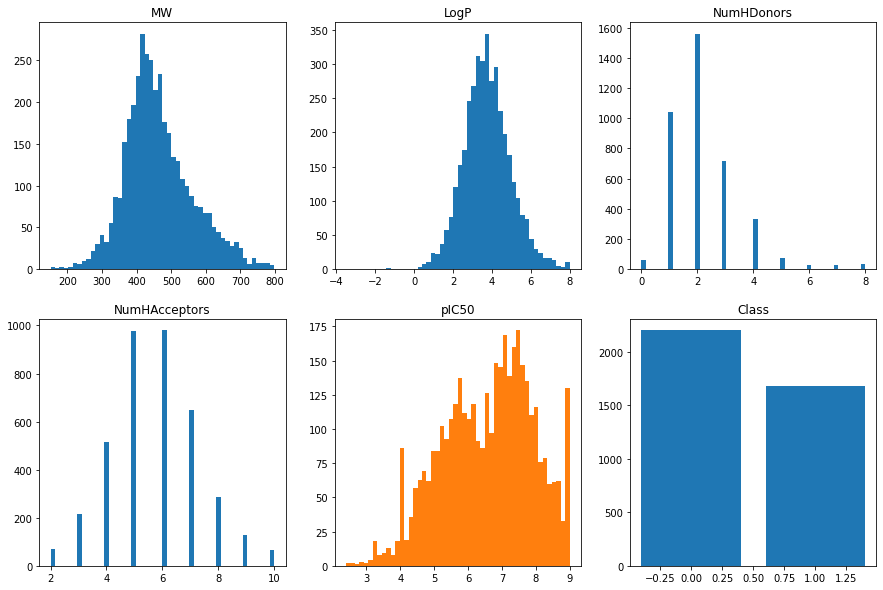

In [97]:
df = pd.read_csv('chembl_bace_bioactivity_data_raw.csv')
df.head()

# neutralize the molecules
def un_charge_molecule(smi):
    try:
        un = rdMolStandardize.Uncharger()
        mol = Chem.MolFromSmiles(smi)
        un_mol = un.uncharge(mol)
        res_smi = Chem.MolToSmiles(un_mol)
        return res_smi
    except:
        return "NaN"
        
# remove trival molecules
def choose_largest_frag(smi):
    try:
        mol = Chem.MolFromSmiles(smi)
        # setup standardization module
        largest_Fragment = rdMolStandardize.LargestFragmentChooser()
        largest_mol = largest_Fragment.choose(mol)
        smi_res = Chem.MolToSmiles(largest_mol)
        return smi_res
    except:
        print("%s failed conversion"%smi)
        return "NaN"
        
df2 = df[df.standard_value.notna()]
print(df2.shape)
df2 = df2[df.canonical_smiles.notna()]
print(df2.shape)
df2 = df2[df2['assay_type']=='B']
print(df2.shape)
df2 = df2[df2['standard_relation']=='=']
print(df2.shape)
df2 = df2[df2['standard_units']=='nM']
print(df2.shape)

df2['canonical_smiles'] = df2['canonical_smiles'].apply(standardize_smiles)
df2['canonical_smiles'] = df2['canonical_smiles'].apply(un_charge_molecule)
df2['canonical_smiles'] = df2['canonical_smiles'].apply(choose_largest_frag)
df2.head()

df2_activity_sub = df2[df2['bao_label']=='single protein format']
df2_activity_sub.shape

df2_activity_sub_nr = df2_activity_sub.drop_duplicates(['canonical_smiles'])
df2_activity_sub_nr.shape

df2_activity_sub_nr.reset_index(drop=True, inplace=True)

df3 = df2_activity_sub_nr[['molecule_chembl_id','canonical_smiles', 'standard_type', 'standard_relation', 'standard_value', 'standard_units']]

def lipinski(smiles, verbose=False):

    moldata= []
    for elem in smiles:
        mol=Chem.MolFromSmiles(elem) 
        moldata.append(mol)
       
    baseData= np.arange(1,1)
    i=0  
    for mol in moldata:        
       
        desc_MolWt = Descriptors.MolWt(mol)
        desc_MolLogP = Descriptors.MolLogP(mol)
        desc_NumHDonors = Lipinski.NumHDonors(mol)
        desc_NumHAcceptors = Lipinski.NumHAcceptors(mol)
           
        row = np.array([desc_MolWt,
                        desc_MolLogP,
                        desc_NumHDonors,
                        desc_NumHAcceptors])   
    
        if(i==0):
            baseData=row
        else:
            baseData=np.vstack([baseData, row])
        i=i+1      
    
    columnNames=["MW","LogP","NumHDonors","NumHAcceptors"]   
    descriptors = pd.DataFrame(data=baseData,columns=columnNames)
    
    return descriptors
    
df_lipinski = lipinski(df3.canonical_smiles)
df3_w_lipinski = pd.concat([df3,df_lipinski], axis=1)

df3_w_lipinski = df3_w_lipinski[(df3_w_lipinski['MW'] < 800) & (df3_w_lipinski['MW'] > 150)]
df3_w_lipinski = df3_w_lipinski[(df3_w_lipinski['LogP'] < 8) & (df3_w_lipinski['LogP'] > -5)]
df3_w_lipinski = df3_w_lipinski[df3_w_lipinski['NumHDonors'] <= 8]
df3_w_lipinski = df3_w_lipinski[df3_w_lipinski['NumHAcceptors'] <= 10]
df3_w_lipinski

# IC50 to pIC50
def pIC50(input):
  molar = input*(10**-9)
  pIC50_val = -np.log10(molar)
  if pIC50_val > 9:
    pIC50_val = 9
  return pIC50_val

# add class info
def pic50_to_2class(pic50):
    if pic50 < 7:
        return 0
    else:
        return 1

df3_w_lipinski['pIC50'] = df3_w_lipinski['standard_value'].apply(pIC50)
df3_w_lipinski['Classification'] = df3_w_lipinski['pIC50'].apply(pic50_to_2class)
df3_w_lipinski

df_final = df3_w_lipinski.reset_index(drop=True)
df_final

df_final.describe()

import matplotlib
import matplotlib.pyplot as plt

fig=plt.figure(figsize=(15,10))
ax1=fig.add_subplot(2,3,1)
ax1.hist(df_final['MW'], bins=50)
plt.title('MW')

ax1=fig.add_subplot(2,3,2)
ax1.hist(df_final['LogP'], bins=50)
plt.title('LogP')

ax1=fig.add_subplot(2,3,3)
ax1.hist(df_final['NumHDonors'], bins=50)
plt.title('NumHDonors')

ax1=fig.add_subplot(2,3,4)
ax1.hist(df_final['NumHAcceptors'], bins=50)
plt.title('NumHAcceptors')

ax1=fig.add_subplot(2,3,5)
ax1.hist(df_final['pIC50'], bins=50)
plt.title('pIC50')

ax1=fig.add_subplot(2,3,5)
ax1.hist(df_final['pIC50'], bins=50)
plt.title('pIC50')

ax1=fig.add_subplot(2,3,6)
counts = df_final['Classification'].value_counts()
ax1.bar(counts.index, counts.values)
plt.title('Class')


In [98]:
df_final.to_csv('chembl_bace_bioactivity_data_processed.csv', index=False)

# PART 3: CDK2


In [ ]:
# Import necessary libraries
import pandas as pd
from chembl_webresource_client.new_client import new_client
import pandas as pd
import molvs as mv
from molvs.standardize import standardize_smiles
from rdkit import Chem
from rdkit.Chem.MolStandardize import rdMolStandardize
from rdkit.Chem import Descriptors, Lipinski
import numpy as np

## get data

In [ ]:
# Target search for coronavirus
target = new_client.target
target_query = target.search('CDK2')
targets = pd.DataFrame.from_dict(target_query)
selected_target = targets.target_chembl_id[8]
selected_target

'CHEMBL301'

In [ ]:
activity = new_client.activity
res = activity.filter(target_chembl_id=selected_target).filter(standard_type="IC50")
df = pd.DataFrame.from_dict(res)
df.shape

(2688, 45)

## data process

(2650, 45)
(2646, 45)
(2628, 45)
(1936, 45)
(1908, 45)


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:30: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:110: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:111: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:143: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous a

Text(0.5, 1.0, 'Class')

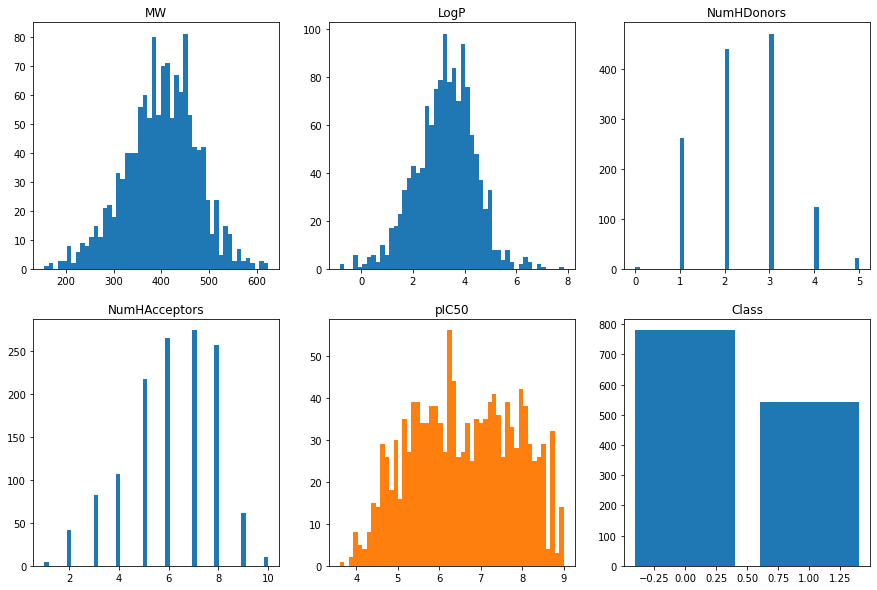

In [99]:
df = pd.read_csv('chembl_cdk2_bioactivity_data_raw.csv')
df.head()

# neutralize the molecules
def un_charge_molecule(smi):
    try:
        un = rdMolStandardize.Uncharger()
        mol = Chem.MolFromSmiles(smi)
        un_mol = un.uncharge(mol)
        res_smi = Chem.MolToSmiles(un_mol)
        return res_smi
    except:
        return "NaN"
        
# remove trival molecules
def choose_largest_frag(smi):
    try:
        mol = Chem.MolFromSmiles(smi)
        # setup standardization module
        largest_Fragment = rdMolStandardize.LargestFragmentChooser()
        largest_mol = largest_Fragment.choose(mol)
        smi_res = Chem.MolToSmiles(largest_mol)
        return smi_res
    except:
        print("%s failed conversion"%smi)
        return "NaN"
        
df2 = df[df.standard_value.notna()]
print(df2.shape)
df2 = df2[df.canonical_smiles.notna()]
print(df2.shape)
df2 = df2[df2['assay_type']=='B']
print(df2.shape)
df2 = df2[df2['standard_relation']=='=']
print(df2.shape)
df2 = df2[df2['standard_units']=='nM']
print(df2.shape)

df2['canonical_smiles'] = df2['canonical_smiles'].apply(standardize_smiles)
df2['canonical_smiles'] = df2['canonical_smiles'].apply(un_charge_molecule)
df2['canonical_smiles'] = df2['canonical_smiles'].apply(choose_largest_frag)
df2.head()

df2_activity_sub = df2[df2['bao_label']=='single protein format']
df2_activity_sub.shape

df2_activity_sub_nr = df2_activity_sub.drop_duplicates(['canonical_smiles'])
df2_activity_sub_nr.shape

df2_activity_sub_nr.reset_index(drop=True, inplace=True)

df3 = df2_activity_sub_nr[['molecule_chembl_id','canonical_smiles', 'standard_type', 'standard_relation', 'standard_value', 'standard_units']]

def lipinski(smiles, verbose=False):

    moldata= []
    for elem in smiles:
        mol=Chem.MolFromSmiles(elem) 
        moldata.append(mol)
       
    baseData= np.arange(1,1)
    i=0  
    for mol in moldata:        
       
        desc_MolWt = Descriptors.MolWt(mol)
        desc_MolLogP = Descriptors.MolLogP(mol)
        desc_NumHDonors = Lipinski.NumHDonors(mol)
        desc_NumHAcceptors = Lipinski.NumHAcceptors(mol)
           
        row = np.array([desc_MolWt,
                        desc_MolLogP,
                        desc_NumHDonors,
                        desc_NumHAcceptors])   
    
        if(i==0):
            baseData=row
        else:
            baseData=np.vstack([baseData, row])
        i=i+1      
    
    columnNames=["MW","LogP","NumHDonors","NumHAcceptors"]   
    descriptors = pd.DataFrame(data=baseData,columns=columnNames)
    
    return descriptors
    
df_lipinski = lipinski(df3.canonical_smiles)
df3_w_lipinski = pd.concat([df3,df_lipinski], axis=1)

df3_w_lipinski = df3_w_lipinski[(df3_w_lipinski['MW'] < 800) & (df3_w_lipinski['MW'] > 150)]
df3_w_lipinski = df3_w_lipinski[(df3_w_lipinski['LogP'] < 8) & (df3_w_lipinski['LogP'] > -5)]
df3_w_lipinski = df3_w_lipinski[df3_w_lipinski['NumHDonors'] <= 8]
df3_w_lipinski = df3_w_lipinski[df3_w_lipinski['NumHAcceptors'] <= 10]
df3_w_lipinski

# IC50 to pIC50
def pIC50(input):
  molar = input*(10**-9)
  pIC50_val = -np.log10(molar)
  if pIC50_val > 9:
    pIC50_val = 9
  return pIC50_val

# add class info
def pic50_to_2class(pic50):
    if pic50 < 7:
        return 0
    else:
        return 1

df3_w_lipinski['pIC50'] = df3_w_lipinski['standard_value'].apply(pIC50)
df3_w_lipinski['Classification'] = df3_w_lipinski['pIC50'].apply(pic50_to_2class)
df3_w_lipinski

df_final = df3_w_lipinski.reset_index(drop=True)
df_final

df_final.describe()

import matplotlib
import matplotlib.pyplot as plt

fig=plt.figure(figsize=(15,10))
ax1=fig.add_subplot(2,3,1)
ax1.hist(df_final['MW'], bins=50)
plt.title('MW')

ax1=fig.add_subplot(2,3,2)
ax1.hist(df_final['LogP'], bins=50)
plt.title('LogP')

ax1=fig.add_subplot(2,3,3)
ax1.hist(df_final['NumHDonors'], bins=50)
plt.title('NumHDonors')

ax1=fig.add_subplot(2,3,4)
ax1.hist(df_final['NumHAcceptors'], bins=50)
plt.title('NumHAcceptors')

ax1=fig.add_subplot(2,3,5)
ax1.hist(df_final['pIC50'], bins=50)
plt.title('pIC50')

ax1=fig.add_subplot(2,3,5)
ax1.hist(df_final['pIC50'], bins=50)
plt.title('pIC50')

ax1=fig.add_subplot(2,3,6)
counts = df_final['Classification'].value_counts()
ax1.bar(counts.index, counts.values)
plt.title('Class')


In [100]:
df_final.to_csv('chembl_cdk2_bioactivity_data_processed.csv', index=False)

In [ ]:
from google.colab import files
files.download('chembl_cdk2_bioactivity_data_processed.csv') 
files.download('chembl_cdk2_bioactivity_data_raw.csv')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>